<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==4.4.0.46 -i https://pypi.douban.com/simple


Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 49.5MB 57kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [6]:
%cd /content/drive/MyDrive/Calibration

/content/drive/MyDrive/Calibration


In [7]:
%cd Social-Distance-Surveillance

/content/drive/MyDrive/Calibration/Social-Distance-Surveillance


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt
from helper_functions import *
import sys

In [44]:
from google.colab.patches import cv2_imshow
original_image_BGR = cv2.imread('data/pedestrians_frame_400.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
main_header = cv2.imread('templates/main_header.jpg')

image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)
# cv2_imshow(original_image_RGB_copy)

image Shape (1080, 1920, 3)


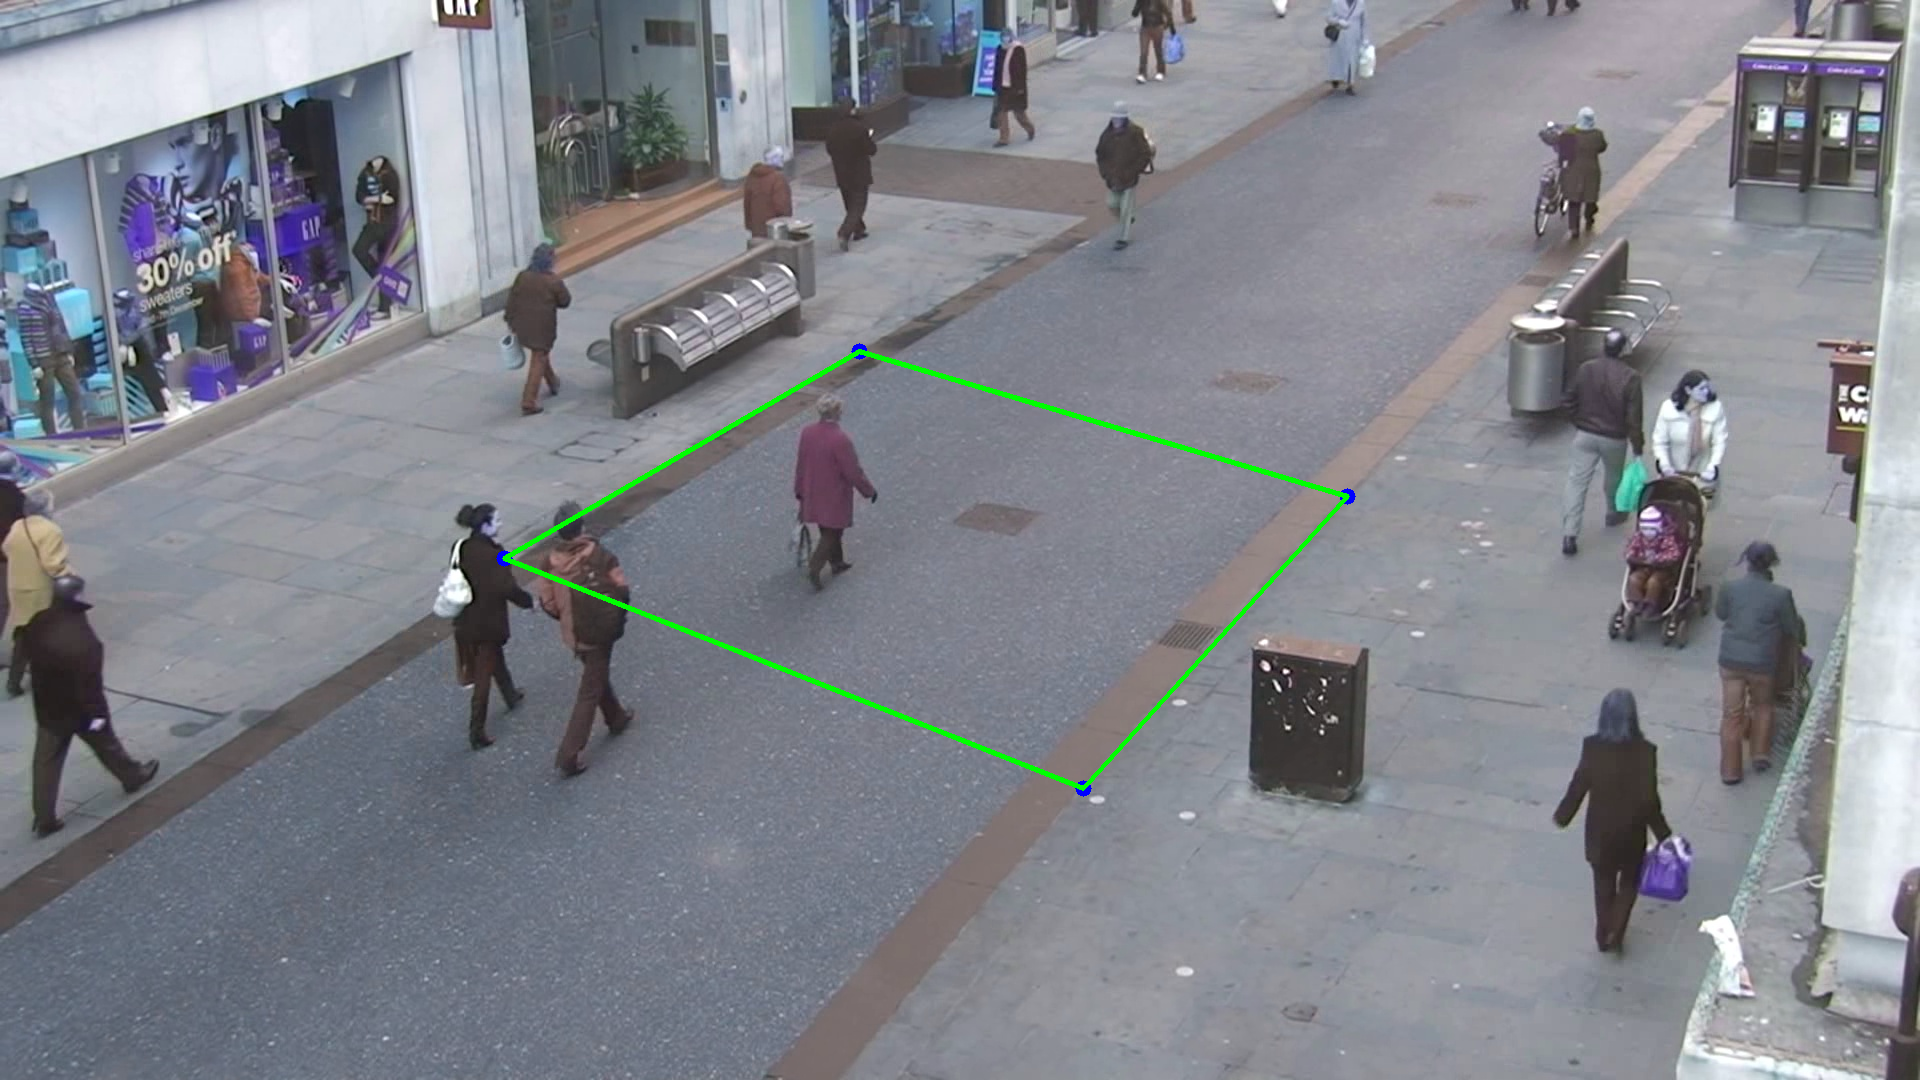

In [45]:
points=np.float32([[859.,351.],
                   [1347.,496.],
                    [1083.,788.],
                   [504.,558.]])
for point in points:
  cv2.circle(original_image_RGB_copy,tuple(point),8,(255,0,0),-1)
points_res=points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy,[points_res],True,(0,255,0),thickness=4)
cv2_imshow(original_image_RGB_copy)


In [46]:
src=points
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

# dst_size=(800,1080)
# dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

The perspective transform matrix:
[[ 1.14682609e+00  2.29497299e+00 -1.54008326e+03]
 [-1.95493521e-01  2.00060002e+00  8.52655739e+02]
 [-1.05325694e-04  1.87058109e-03  1.00000000e+00]]


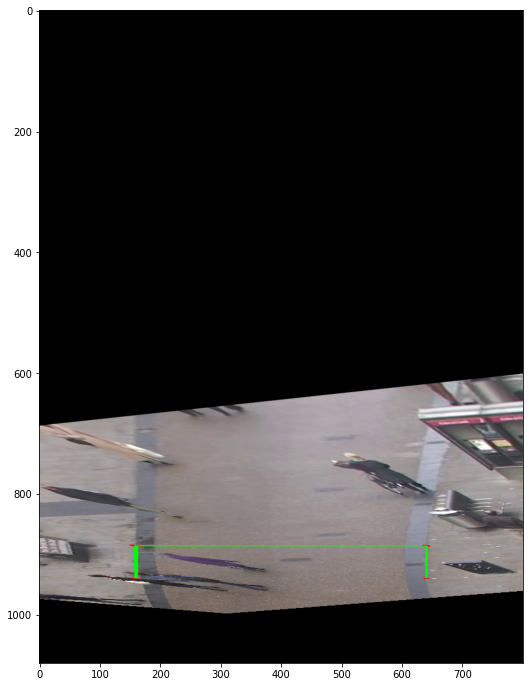

In [47]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [48]:

%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [49]:
from darknet import *
confidence_threshold = 0.5
nms_threshold = 0.4

width = 608
height = 608

config = '/content/drive/MyDrive/darknet/cfg/yolov4.cfg'
weights = '/content/drive/MyDrive/darknet/yolov4.weights'
classes = '/content/drive/MyDrive/darknet/cfg/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

In [50]:

%cd /content/drive/MyDrive/Calibration/Social-Distance-Surveillance

/content/drive/MyDrive/Calibration/Social-Distance-Surveillance


In [51]:
model = create_model(config, weights)
output_layers = get_output_layers(model)

In [52]:
blob = blob_from_image(original_image_RGB, (width, height))
model.setInput(blob)
#Trả về vị trí box (x,y,w_h,w_w,confidence)
outputs = model.forward(output_layers)

In [53]:
boxes = get_image_boxes(outputs, image_width, image_height, coco_classes)
birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)

In [59]:
def get_red_green_boxes(distance_allowed,birds_eye_points,boxes):
    red_boxes = []
    green_boxes = []

    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][6:]
                cxj,cyj = new_boxes[j][6:]
                distance = eucledian_distance([cxi,cyi], [cxj,cyj])
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])

    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))

    return (green_boxes, red_boxes)

In [66]:
min_distance = 50
green_box, red_box = get_red_green_boxes(min_distance, birds_eye_points, boxes)

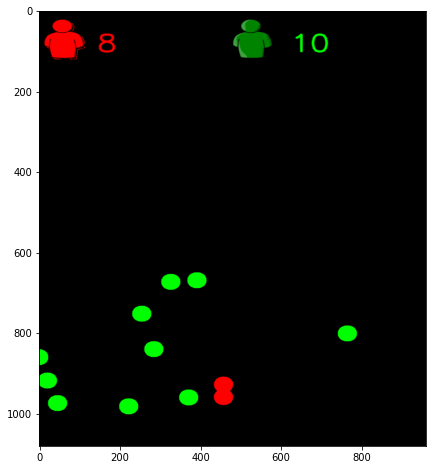

In [67]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(birds_eye_view_image, cv2.COLOR_RGB2BGR))
plt.show()

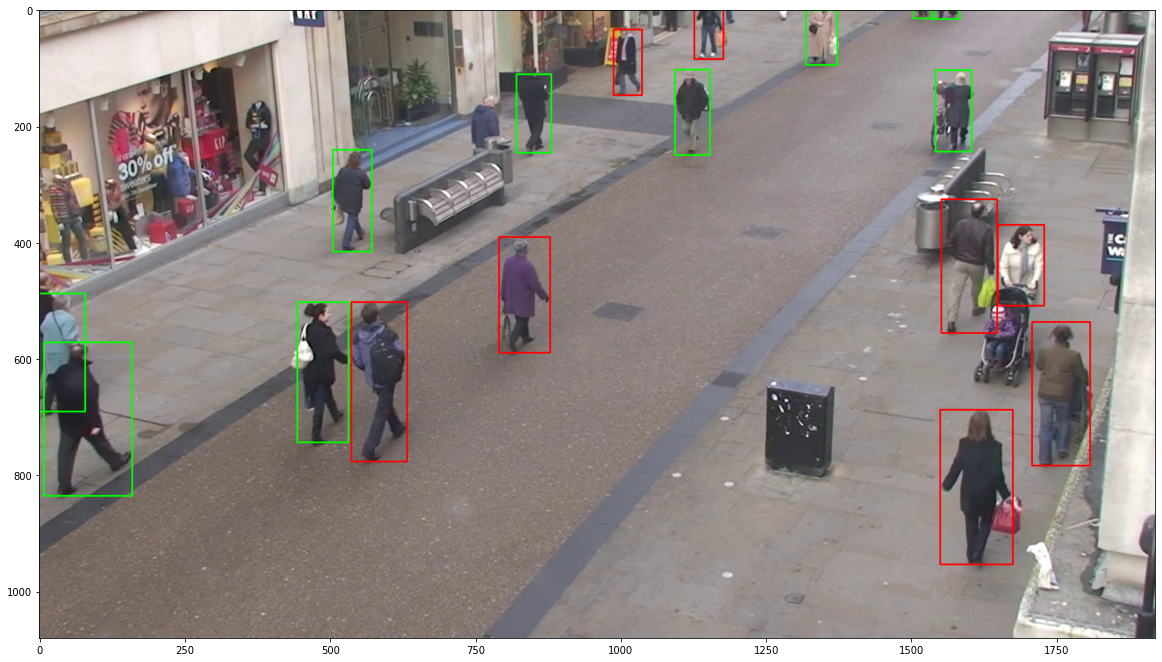

In [68]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()